In [58]:
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import re
import requests
import seaborn as sns

from db import create_connection
from db import (
    articles,
    services,
    urls
)

In [59]:
connection = create_connection()

# Get data

In [60]:
data = articles.get_articles(connection)

In [61]:
pd.set_option('max_colwidth', 100)
df = pd.DataFrame(data, columns = ['publication_date',
                                    'author',
                                    'title',
                                   'url',
                                    'koronawirus_in_text',
                                    'koronawirus_in_title'])

In [62]:
df.sample(frac = 0.0035)

,publication_date,author,title,url,koronawirus_in_text,koronawirus_in_title
1099,NaT,None,None,https://www.se.pl/lublin/w-spsk-nr-4-zrobi-sie-cieplej-trwa-termomodernizacja-budynkow-audio-aa-...,NaN,NaN
1465,2020-08-10 09:37:00,Marek Targoński,"Grozili, że ZGWAŁCĄ I ZABIJĄ. BANDYCI nie mieli litości. HORROR w Lublinie",https://lublin.se.pl/grozili-ze-zgwalca-i-zabija-bandyci-nie-mieli-litosci-horror-w-lublinie-aa-...,0.0,0.0
440,2020-06-11 06:33:00,BM,Chodel: Tragiczne skutki wybuchu gazu. W nocy odnaleziono DWA ciała!,https://www.se.pl/lublin/chodel-tragiczne-skutki-wybuchu-gazu-w-nocy-odnaleziono-dwa-ciala-aa-Ra...,0.0,0.0
1712,2020-06-19 09:11:00,AP,Brzeziny. To nie matka POSTRZELIŁA 4-letnią córkę! ZASKAKUJĄCE ustalenia prokuratury,https://lublin.se.pl/brzeziny-to-nie-matka-postrzelila-4-letnia-corke-zaskakujace-ustalenia-prok...,0.0,0.0
1973,2020-01-17 12:11:00,mt,SKANDAL! Udawał „lekarza bez granic”. Mieszkanka Lublina STRACIŁA OGROMNE PIENIĄDZE!,https://www.se.pl/lublin/skandal-udawal-lekarza-bez-granic-mieszkanka-lublina-stracila-ogromne-p...,0.0,0.0
52,2020-08-06 10:18:00,Rafał Strzelec,"Koronawirus: REKORDOWY WZROST! Zakażenia +726. Ile mamy respiratorów? Ofiary +18, Ozdrowieńcy +321",https://lublin.se.pl/koronawirus-w-polsce-zakazenia-726-ofiary-18-ozdrowiency-321-rekordowy-wzro...,21.0,1.0
428,2020-06-16 11:45:00,Mgorecki,Lublin: Ukradli ponad 70 tysięcy złotych! Udało się dzięki TEJ metodzie [WIDEO],https://lublin.se.pl/lbulin-ukradli-ponad-70-tysiecy-zlotych-udalo-sie-dzieki-tej-poularnej-meto...,0.0,0.0


# Clean data

### initial data check, organize and clearing

In [63]:
df.shape

(2002, 6)

In [64]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2002 entries, 0 to 2001
Data columns (total 6 columns):
publication_date        1469 non-null datetime64[ns]
author                  1469 non-null object
title                   1469 non-null object
url                     2002 non-null object
koronawirus_in_text     1469 non-null float64
koronawirus_in_title    1469 non-null float64
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 854.2 KB


In [65]:
df.dropna(inplace=True)
df.shape

(1469, 6)

In [66]:
df.count()

publication_date        1469
author                  1469
title                   1469
url                     1469
koronawirus_in_text     1469
koronawirus_in_title    1469
dtype: int64

### column: publication_day

In [67]:
df.insert(loc=1, column='publication_day', value=df['publication_date'].dt.strftime('%Y-%m-%d'))
df.sample(frac = 0.002)

,publication_date,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
267,2020-07-08 21:41:00,2020-07-08,Amadeusz Calik,Ogromny SKANDAL na pogrzebie na Lubelszczyźnie. Wierni nie mogli w to uwierzyć!,https://lublin.se.pl/ogromny-skandal-na-pogrzebie-na-lubelszczyznie-wierni-nie-mogli-w-to-uwierz...,0.0,0.0
529,2020-05-18 09:33:00,2020-05-18,Mucha,"Zrobił tak, jak zrobili jemu. Nietypowe początki młodego oszusta",https://www.se.pl/lublin/zrobil-tak-jak-zrobili-jemu-nietypowe-poczatki-mlodego-oszusta-aa-5YYe-...,0.0,0.0
528,2020-05-18 10:52:00,2020-05-18,Mucha,Z PRZERAŻENIEM dzwonili na policję! A on tylko... wybrał się na spacer. KOŃ w Lubartowie,https://www.se.pl/lublin/z-przerazeniem-dzwonili-na-policje-a-on-tylko-wybral-sie-na-spacer-aa-o...,0.0,0.0


In [68]:
df.publication_day.value_counts().head()

2020-06-29    28
2020-07-08    26
2020-07-01    24
2020-07-03    22
2020-07-14    21
Name: publication_day, dtype: int64

In [69]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 7 columns):
publication_date        1469 non-null datetime64[ns]
publication_day         1469 non-null object
author                  1469 non-null object
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null float64
koronawirus_in_title    1469 non-null float64
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 833.1 KB


In [70]:
df['publication_day'] = df['publication_day'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 7 columns):
publication_date        1469 non-null datetime64[ns]
publication_day         1469 non-null category
author                  1469 non-null object
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null float64
koronawirus_in_title    1469 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), object(3)
memory usage: 764.1 KB


### column: publication_month

In [71]:
df.insert(loc=1, column='publication_month', value=df['publication_date'].dt.strftime('%Y-%m'))
df.sample(frac = 0.001)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
545,2020-05-13 13:28:00,2020-05,2020-05-13,Mucha,Wisznice: Policjant po służbie URATOWAŁ BOCIANA. Ptak jest już bezpieczny,https://www.se.pl/lublin/policjant-po-sluzbie-uratowal-bociana-ptak-jest-juz-bezpieczny-aa-kkee-...,0.0,0.0


### column: author

In [72]:
df['author'].value_counts()[:60]

mt                                     332
Mucha                                  146
Marek Targoński                        132
Karolina Januszek                       88
MTA                                     78
Mariusz Mucha                           76
Mucha, mta                              54
AP                                      36
OM                                      32
KM                                      25
Monika Kowalewicz                       22
Bartłomiej Ważny                        22
AC                                      20
MK                                      16
Mateusz Kasiak                          16
Michał Michalak                         16
gk                                      15
Agnieszka Niećko                        15
Jacek Werner                            14
Artykuł sponsorowany                    13
EIB                                     13
Olka Mazur                              13
Sylwia Sitka-Czerniak                   13
maal       

In [73]:
df['author'] = df['author'].replace(['mt', 'mt; wideo: Tygodnik Zamojski'],'Marek Targoński')
df['author'] = df['author'].replace(['Mucha', 'mucha'],'Mariusz Mucha')
df['author'] = df['author'].replace(['ŁT'],'Łukasz Trybulski')
df['author'] = df['author'].replace(['Mateusz Kasiak (Radio Eska)'],'Mateusz Kasiak')
df['author'] = df['author'].replace(['KaJa'],'Karolina Januszek')
df['author'] = df['author'].replace(['RS'],'Rafał Strzelec')
df['author'] = df['author'].replace(['gk'],'Grzegorz Kluczyński')
df['author'] = df['author'].replace([''],'Nieznany')

regex_pattern = re.compile(r'(.*,.*|.*/.*|Redakcja ESKA INFO|Nieznany|Akcja partnerska)', re.I)
df['author'] = df['author'].replace(regex_pattern,'Więcej autorów lub nieznany')

df['author'].value_counts()[:15]

Marek Targoński                464
Mariusz Mucha                  223
Więcej autorów lub nieznany    135
Karolina Januszek               97
MTA                             78
AP                              36
OM                              32
KM                              25
Bartłomiej Ważny                22
Monika Kowalewicz               22
Grzegorz Kluczyński             22
AC                              20
Mateusz Kasiak                  17
MK                              16
Michał Michalak                 16
Name: author, dtype: int64

In [74]:
df['author'] = df['author'].astype('category')
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1469 entries, 0 to 2001
Data columns (total 8 columns):
publication_date        1469 non-null datetime64[ns]
publication_month       1469 non-null object
publication_day         1469 non-null category
author                  1469 non-null category
title                   1469 non-null object
url                     1469 non-null object
koronawirus_in_text     1469 non-null float64
koronawirus_in_title    1469 non-null float64
dtypes: category(2), datetime64[ns](1), float64(2), object(3)
memory usage: 761.8 KB


In [20]:
df.loc[[919, 1979, 1965], 'koronawirus_in_text'] = 0

In [48]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
df_with_koronawirus_in_title['author'].value_counts()[:1]

Marek Targoński    185
Name: author, dtype: int64

In [35]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text['author'].value_counts()[:1]


Marek Targoński    224
Name: author, dtype: int64

# Project

### Łączna ilość artykułów

In [138]:
df.shape[0]

1469

### Ilość opublikowanych artykułów w każdym miesiącu

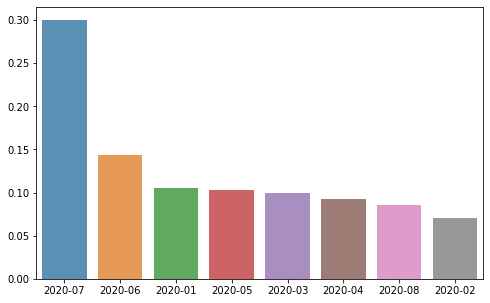

In [198]:
publication_month_count = df.publication_month.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_count.index, publication_month_count.values, alpha=0.8)
plt.show()

### Pierwsze opublikowane artykuły o covid

In [110]:
covid_articles = df.sort_values(by=['koronawirus_in_title', 'publication_date'], ascending=[False, True])
covid_articles[['publication_date', 'author', 'title', 'url']].head(8)

,publication_date,author,title,url
1949,2020-01-29 15:07:00,MPGT,"Koronawirus na Lubelszczyźnie? Sześć osób trafiło na badania! [AKTUALIZACJA, AUDIO]",https://www.se.pl/lublin/koronawirus-na-lubelszczyznie-lecieli-samolotem-z-pasazerami-z-chin-tra...
1945,2020-01-31 10:46:00,Marek Targoński,Koronawirus z Chin: Gdzie jest? Sprawdź swój region! Lubelskie jest bezpieczne? [MAPA],https://www.se.pl/lublin/koronawirus-z-chin-gdzie-jest-sprawdz-swoj-region-lubelskie-jest-bezpie...
1937,2020-02-05 16:54:00,AC,Koronawirus w Lublinie? Mężczyzna zgłosił się z do kliniki chorób zakaźnych! [AKTUALIZACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-mezczyzna-zglosil-sie-z-objawami-do-kliniki-chor...
806,2020-02-08 22:25:00,Więcej autorów lub nieznany,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...
753,2020-02-26 09:33:00,Marek Targoński,Koronawirus w Lubelskiem? Wrócili z Włoch – 27 osób pod lupą sanepidu. „Zwiększone ryzyko” [AKTU...,https://www.se.pl/lublin/koronawirus-w-lubelskiem-wrocili-z-wloch-27-osob-pod-lupa-sanepidu-zwie...
85,2020-02-26 13:31:00,Więcej autorów lub nieznany,Koronawirus w Lublinie? Uczelnia zawiesza rekrutację cudzoziemców. „Wszyscy się boimy”,https://www.se.pl/lublin/koronawirus-w-lublinie-uczelnia-zawiesza-rekrutacje-cudzoziemcow-wszysc...
751,2020-02-26 14:58:00,Więcej autorów lub nieznany,"Koronawirus w Lubelskiem? Dwie osoby w szpitalu! Trwają badania [AKTUALIZACJA, AUDIO]",https://www.se.pl/lublin/koronawirus-na-lubelszczyznie-dwie-osoby-w-szpitalu-trwaja-badania-aa-a...
1919,2020-02-27 07:42:00,Marek Targoński,Koronawirus. Gdzie zgłosić się z objawami w Lublinie? Oddziały zakaźne w Lubelskiem [ADRESY],https://www.se.pl/lublin/koronawirus-gdzie-zglosic-sie-z-objawami-w-lublinie-oddzialy-zakazne-w-...


### łączna ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [44]:
# df.koronawirus_in_title.sum()

df.groupby('koronawirus_in_title').count()

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text
koronawirus_in_title,,,,,,,
0.0,1134,1134,1134,1134,1134,1134,1134
1.0,335,335,335,335,335,335,335


### średnia ilość artykułów mających w tytule słowo z grupy "koronawirus"

In [89]:
df.koronawirus_in_title.mean()

0.22804628999319265

### Ilość opublikowanych artykułów ze słowem "k" w tytule w każdym miesiącu

In [120]:
df_with_koronawirus_in_title = df.where(df["koronawirus_in_title"] > 0).dropna()
df_with_koronawirus_in_title.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_anywhere,koronawirus_in_text,koronawirus_in_title
0,2020-08-15 09:10:00,2020-08,2020-08-15,Marek Targoński,Lubelskie: Ponad 360 aktywnych przypadków COVID-19. Już 21 ognisk epidemii koronawirusa,https://lublin.se.pl/lubelskie-ponad-360-aktywnych-przypadkow-covid-19-juz-21-ognisk-epidemii-ko...,0.0,14.0,1.0


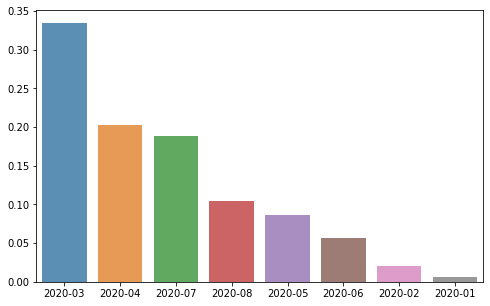

In [121]:
publication_month_with_koronawirus_in_title_count = df_with_koronawirus_in_title.publication_month.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_title_count.index, publication_month_with_koronawirus_in_title_count.values, alpha=0.8)
plt.show()

### łączna ilość artykułów mających w tekście słowo z grupy "koronawirus"

In [26]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].count()

533

In [31]:
koronawirus_in_text_true.mean()

0.36283185840707965

### Ilość opublikowanych artykułów ze słowem "k" w tekście w każdym miesiącu

In [123]:
df_with_koronawirus_in_text = df.where(df["koronawirus_in_text"] > 0).dropna()
df_with_koronawirus_in_text.head(1)

,publication_date,publication_month,publication_day,author,title,url,koronawirus_anywhere,koronawirus_in_text,koronawirus_in_title
0,2020-08-15 09:10:00,2020-08,2020-08-15,Marek Targoński,Lubelskie: Ponad 360 aktywnych przypadków COVID-19. Już 21 ognisk epidemii koronawirusa,https://lublin.se.pl/lubelskie-ponad-360-aktywnych-przypadkow-covid-19-juz-21-ognisk-epidemii-ko...,0.0,14.0,1.0


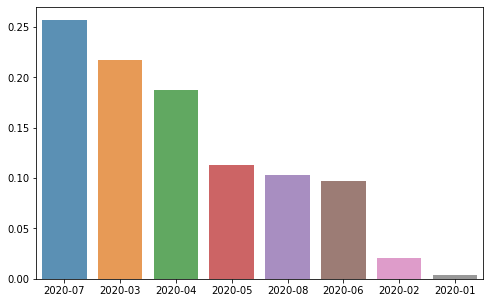

In [124]:
publication_month_with_koronawirus_in_text_count = df_with_koronawirus_in_text.publication_month.value_counts(normalize=True)
plt.figure(figsize=(8, 5))
sns.barplot(publication_month_with_koronawirus_in_text_count.index, publication_month_with_koronawirus_in_text_count.values, alpha=0.8)
plt.show()

### łączna ilość słów z grupy "koronawirus"

In [125]:
df.koronawirus_in_text.sum()

5790.0

### średnia ilość słów z grupy "koronawirus" biorąc pod uwagę tematyczne

In [23]:
koronawirus_in_text_true = df['koronawirus_in_text'] > 0
df['koronawirus_in_text'][koronawirus_in_text_true].mean()

10.863039399624766

### Artykuł z największą ilością słów z serii "covid"

In [40]:
# df.loc[df.koronawirus_in_text.idxmax()]

# df['koronawirus_in_text_rank'] = df['koronawirus_in_text'].rank(ascending=False)
# df.sort_values(by='koronawirus_in_text', ascending=False).head(15)

# df.sort_values(by='koronawirus_in_text', ascending=False)[:5]

df.nlargest(n=5, columns='koronawirus_in_text')

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
1833,2020-04-16 22:42:00,2020-04,2020-04-16,Więcej autorów lub nieznany,Przełom w walce z koronawirusem?! ARCYWAŻNE zmiany ogłoszone przez rząd. Koronawirus w Polsce [Z...,https://www.se.pl/lublin/liczba-zgonow-i-zakazonych-rosnie-najnowsze-informacje-oraz-statystyki-...,500.0,1.0
1851,2020-04-07 07:00:00,2020-04,2020-04-07,Więcej autorów lub nieznany,Szokujący bilans koronawirusa w Polsce. Ważne słowa prezydenta Dudy. Groza w UK [ZAPIS RELACJI N...,https://www.se.pl/lublin/koronawirus-w-polsce-dzis-niedziela-palmowa-pierwsza-taka-w-historii-ko...,461.0,1.0
747,2020-03-04 22:25:00,2020-03,2020-03-04,Więcej autorów lub nieznany,Koronawirus w Polsce! Oto konsekwencje: wzrost cen i wysoki popyt [ZAPIS RELACJI NA ŻYWO],https://www.se.pl/lublin/koronawirus-w-polsce-tytul-relacja-na-zywo-aa-jzM9-R6pH-GAfM.html,313.0,1.0
709,2020-03-19 09:22:00,2020-03,2020-03-19,Marek Targoński,Koronawirus Lubelskie: COVID-19 na Lubelszczyźnie. Kto i gdzie choruje? Kim są pacjenci?,https://www.se.pl/lublin/koronawirus-lubelskie-covid-19-na-lubelszczyznie-kto-i-gdzie-choruje-ki...,43.0,1.0
806,2020-02-08 22:25:00,2020-02,2020-02-08,Więcej autorów lub nieznany,KORONAWIRUS w Lublinie? Znamy wyniki badań! NOWE INFORMACJE [RELACJA],https://www.se.pl/lublin/koronawirus-w-lublinie-pacjent-trafil-do-szpitala-trwaja-badania-audio-...,29.0,1.0


In [41]:
df[koronawirus_in_title_true & ~ koronawirus_in_text_true].head()

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_text,koronawirus_in_title
681,2020-03-26 16:50:00,2020-03,2020-03-26,Mariusz Mucha,Rajcy z Lublina nie przestraszyli się pandemii,https://www.se.pl/lublin/rajcy-z-lublina-nie-przestraszyli-sie-pandemii-aa-hPDP-JqAb-RkZg.html,0.0,1.0


In [47]:
df.groupby('koronawirus_in_text').count()

,publication_date,publication_month,publication_day,author,title,url,koronawirus_in_title
koronawirus_in_text,,,,,,,
0.0,936,936,936,936,936,936,936
1.0,59,59,59,59,59,59,59
2.0,74,74,74,74,74,74,74
3.0,54,54,54,54,54,54,54
4.0,33,33,33,33,33,33,33
5.0,27,27,27,27,27,27,27
6.0,18,18,18,18,18,18,18
7.0,28,28,28,28,28,28,28
8.0,17,17,17,17,17,17,17
